# Лабораторная работа №4 - Системы с прямой адаптацией
Уравнения объекта и регулятора основного контура (без адаптации).

$\dot P = - P^3 + dm + v(t)$
<br>
$\dot dm = -dm + G \, tanh(\omega)$
<br>
$w = c_1 P + c_2 dm + c_3$

## 1. Определение вспомогательных объектов в Python
Определяем модель объекта.

In [1]:
import math

def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                v = finish_value
            else:
                v = init_value
            return [ -math.pow(x[0],3) + x[1] + v, -x[1] + uc] 
    
        return F_internal
    return F_with_control

Базовый класс для реализации регулятора, программа моделирования и вывода результатов на экран.

In [2]:
import numpy
import matplotlib.pyplot as plt 
import scipy.integrate as mdl 

class PLC:
    def __init__(self, gain, step):
        self.last_t = 0.0
        self.last_call_t = 0.0
        self.last_u = 0
        self.step = step
        self.last_e = 0.0
        self.gain = gain
        self.u = []
        self.ulim = []
        self.t = []
        
    def getLimitedOutput(self,value):
        return math.tanh(value)
        
    def addOutputValue(self,time,value):
        self.t.append(time)
        self.u.append(value)
        self.ulim.append(self.getLimitedOutput(value))
        
    def output(self, x, t):
        self.addOutputValue(t, self.last_u)
        self.last_u = self.control(x, t)
        self.last_t = t
        self.addOutputValue(t,self.last_u)
        
        return self.gain*self.ulim[-1]

def calculate(func, x0, step, time, plc):
    result = {'t': [], 'u':[]}
    for i in range(0,len(x0)):
        result['x' + str(i + 1)] = []
    rstep = plc.step
    ode_step = step
    timev = numpy.linspace(0.0, time, int(time/rstep+1))
    for ti in timev:
        uk = plc.output(x0, ti)
        tk = numpy.linspace(ti, ti+rstep, int(rstep/ode_step+1))
        y = mdl.odeint(func(uk), x0, tk)
        x0 = y[-1]
        result['t'].extend(tk[:-1])
        for i in range(0,len(x0)):
            result['x' + str(i + 1)].extend(y[:-1,i])
        result['u'].extend([uk for i in tk[:-1]])
    return result

def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-') 
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--') 
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.ulim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')  
    plt.ylim([-2.0, 2.0])
    plt.show()

### 2. Адаптивный регулятор с обобщённой ошибкой настройки
Реализация алгоритма адаптивного управления.

In [3]:
class ADCS_gerr(PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_gerr,self).__init__(gain,step=dt)
        self.g = speed
        self.Pd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'dy':[], 'ddy':[], 'sigma':[]}
        self.y_last = None
        self.y_last_last = None
        
    def optimize(self, x, t):
        y = x[0] - self.Pd
        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        if self.y_last_last is not None:
            dy = (y - self.y_last)/self.dt
            ddy = (self.y_last - 2.0*self.y_last + self.y_last_last) / (self.dt**2)
            sigma = ddy + 3.0*dy + 2.0*y
            self.coeff['sigma'].append(sigma)

            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]

            c1 = c1 - self.g*sigma*x[0]
            c2 = c2 - self.g*sigma*x[1]
            c3 = c3 - self.g*sigma

            self.coeff['c1'].append(c1)
            self.coeff['c2'].append(c2)
            self.coeff['c3'].append(c3)
        else:
            self.coeff['sigma'].append(0.0)
            self.coeff['c1'].append(self.c10)
            self.coeff['c2'].append(self.c20)
            self.coeff['c3'].append(self.c30)
            
        if self.y_last is not None:
            self.y_last_last = self.y_last
        
        self.y_last = y
    
    def control(self, x, t):
        self.optimize(x, t)
        
        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]
        
        return c1*x[0] + c2*x[1] + c3

Моделирование регулятора с функцией обобщённой ошибки

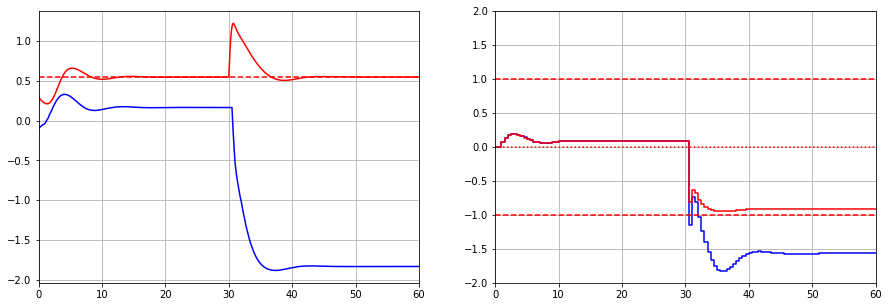

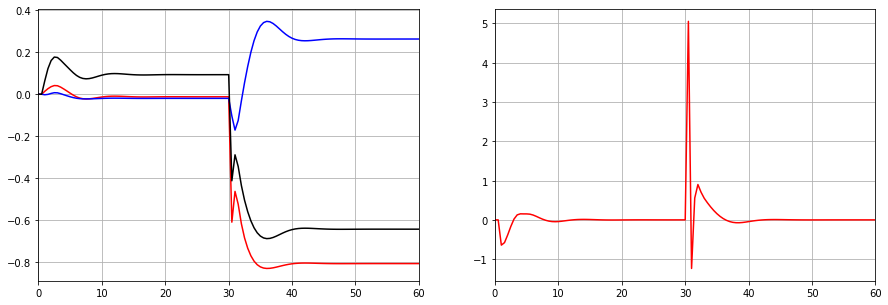

In [4]:
v0_init = 0.0
v0_finish = 2.0
change_time = 30
goal = 0.55
gain = 2
step = 0.5
mod_step = 0.1
tk = 60
x0 = [0.3, -0.1]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_gerr(goal=goal, gain=gain, dt=step, speed=0.1)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',# [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['c2'], 'b',# [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['sigma'], 'r')# [0, tk], [-1, -1], 'r--',
plt.grid()
plt.xlim([0, tk])
plt.show()

## 2. Регулятор на базе алгоритма скоростного градиента
Программа расчета управления

In [5]:
class ADCS_spgrad(PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_spgrad,self).__init__(gain, dt)
        self.g = speed
        self.Pd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'Q':[]}
        
    def optimize(self, x, t):
        y = x[0] - self.Pd
        Q = y**2
        
        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        self.coeff['Q'].append(Q)

        if len(self.coeff['c1'])>0:
            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]
        else:
            c1 = 0.0
            c2 = 0.0
            c3 = 0.0

        c1 = c1 - self.g*y*x[0]
        c2 = c2 - self.g*y*x[1]
        c3 = c3 - self.g*y

        self.coeff['c1'].append(c1)
        self.coeff['c2'].append(c2)
        self.coeff['c3'].append(c3)
    
    def control(self, x, t):
        self.optimize(x, t)
        
        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]
        
        return c1*x[0] + c2*x[1] + c3

Моделирование системы с регулятором

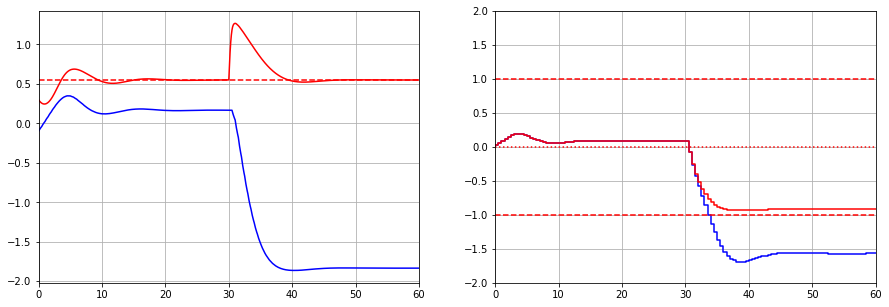

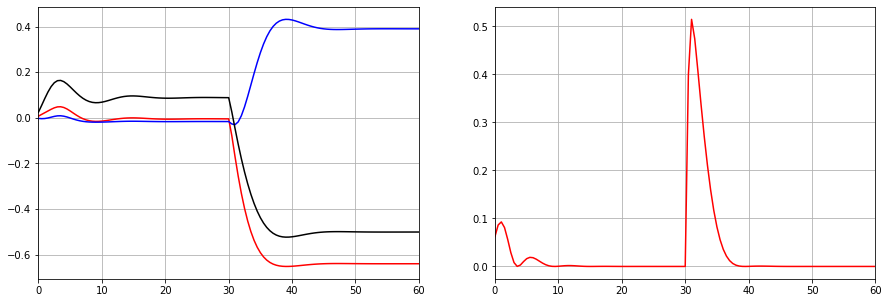

In [6]:
v0_init = 0.0
v0_finish = 2.0
change_time = 30
goal = 0.55
gain = 2
step = 0.5
mod_step = 0.1
tk = 60
x0 = [0.3, -0.1]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_spgrad(goal=goal, gain=gain, dt=step, speed=0.1)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',
         reg.coeff['t'], reg.coeff['c2'], 'b',
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['Q'], 'r')
plt.grid()
plt.xlim([0, tk])
plt.show()